# Proyek Klasifikasi Gambar: [Intel-image-classification]
- **Nama:** geervan thanra
- **Email:** mc008d5y2414@student.devacademy.id
- **ID Dicoding:** Bread

## Import Semua Packages/Library yang Digunakan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import cv2
import skimage
import os
import shutil
import random
import json
from PIL import Image
from skimage.transform import rotate, resize
from skimage import img_as_ubyte
from tqdm.notebook import tqdm as tqdm
import warnings

In [2]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
#kaggle directories
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test"

In [4]:
def get_all(pathdir):
    image_paths = []
    for root, dirs, files in os.walk(pathdir):
        for file in files:
            if file.lower():
                fullpath = os.path.join(root, file)
                image_paths.append(fullpath)
    return image_paths

In [5]:
img_train = get_all(train_dir)
img_test = get_all(test_dir)

print(len(img_train))
print(len(img_test))

14034
3000


In [6]:
def show_images(imagePath, title="Images"):
    plt.figure(figsize=(20, 5))
    for i, img_path in enumerate(imagePath):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(imagePath), i + 1)
        plt.imshow(img_rgb)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

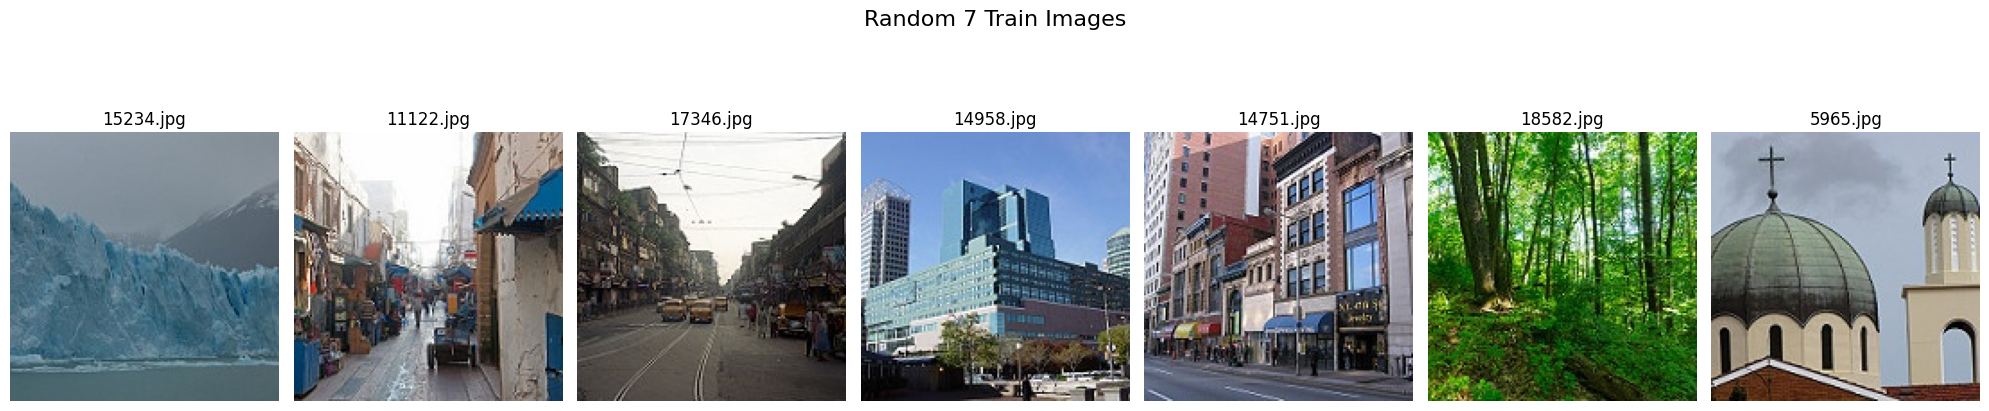

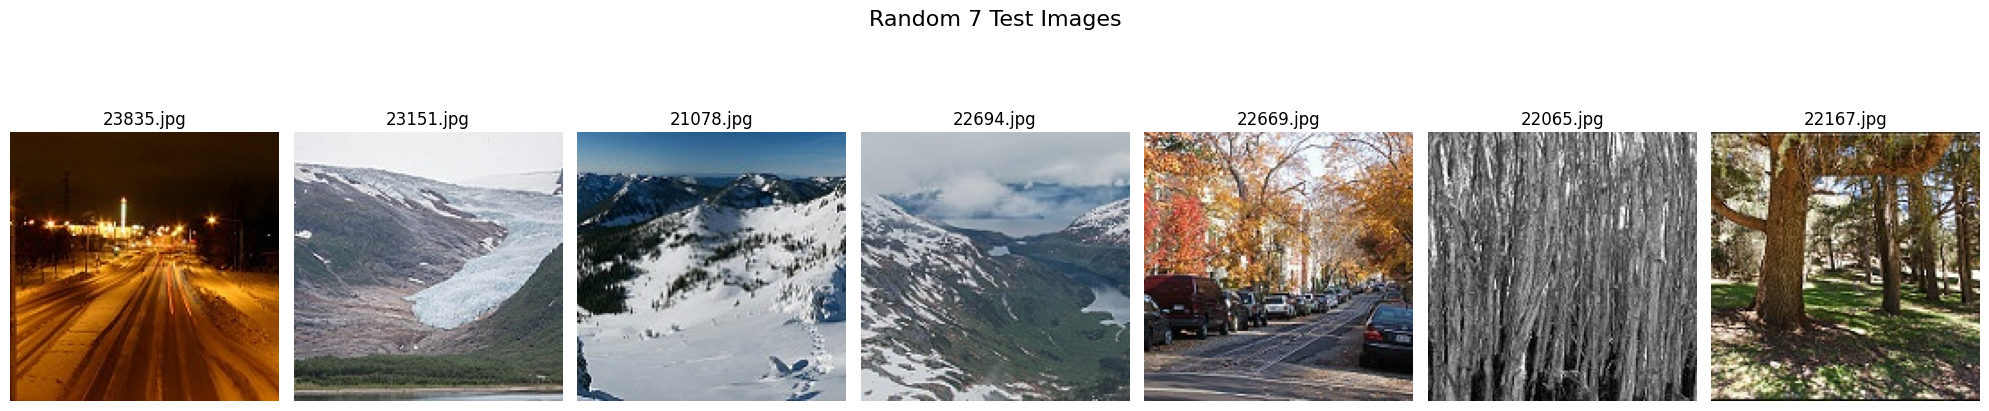

In [7]:
ran_train = random.sample(img_train, 7)
ran_test = random.sample(img_test, 7)

show_images(ran_train, title="Random 7 Train Images")
show_images(ran_test, title="Random 7 Test Images")

In [8]:
#check subfolders
sub_folder =[]
for dirs in os.scandir(train_dir):
    sub_folder.append(dirs.name)
    print(dirs.name)

mountain
street
buildings
sea
forest
glacier


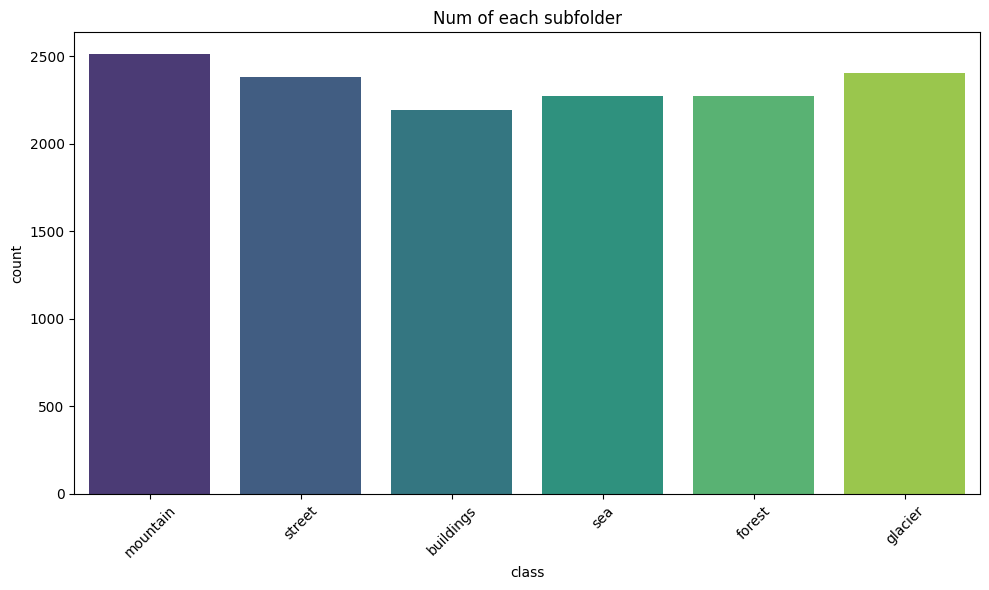

In [9]:
subfolder_counts = []
for k in os.scandir(train_dir):
    if k.is_dir():
        files = os.listdir(k.path)
        count = len([f for f in files])
        subfolder_counts.append( count)

frame = pd.DataFrame({
    'class': sub_folder,
    'count': subfolder_counts
})

plt.figure(figsize=(10, 6))
sns.barplot(data=frame, x='class', y='count', palette='viridis')
plt.title("Num of each subfolder")
plt.xlabel("class")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

dari grafik diatas dapat diperhatikan bahwa num data pada setiap class cukup deket

### Data Preprocessing

#### Split Dataset

In [10]:
#df
class_name_label = {sub: i for i, sub in enumerate(sub_folder)}
print(class_name_label)
print(len(class_name_label))

{'mountain': 0, 'street': 1, 'buildings': 2, 'sea': 3, 'forest': 4, 'glacier': 5}
6


In [11]:
#preprocessing
img_size = 150

def pull_data():
    data = [train_dir, test_dir]
    output = []

    for n in data:
        images = []
        labels = []

        for subfolder in os.listdir(n):
            label = class_name_label[subfolder]
            sub_path = os.path.join(n, subfolder)
    
            for file in tqdm(os.listdir(sub_path), desc=f"{sub_path}"):
                    img_path = os.path.join(sub_path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_size, img_size))
            
                    images.append(img)
                    labels.append(label)

        images = np.array(images, dtype='float32')/255
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))

    return output

In [12]:
(train_images, train_labels), (test_images, test_labels) = pull_data()

train_images, train_labels = shuffle(train_images, train_labels,
                                     random_state=42)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Val Images Shape:", val_images.shape)
print("Val Labels Shape:", val_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain:   0%|          | 0/2512 [00:00<?, ?it/s…

/kaggle/input/intel-image-classification/seg_train/seg_train/street:   0%|          | 0/2382 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_train/seg_train/buildings:   0%|          | 0/2191 [00:00<?, ?it/…

/kaggle/input/intel-image-classification/seg_train/seg_train/sea:   0%|          | 0/2274 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_train/seg_train/forest:   0%|          | 0/2271 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_train/seg_train/glacier:   0%|          | 0/2404 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/mountain:   0%|          | 0/525 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/street:   0%|          | 0/501 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/buildings:   0%|          | 0/437 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/sea:   0%|          | 0/510 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/forest:   0%|          | 0/474 [00:00<?, ?it/s]

/kaggle/input/intel-image-classification/seg_test/seg_test/glacier:   0%|          | 0/553 [00:00<?, ?it/s]

Train Images Shape: (11227, 150, 150, 3)
Train Labels Shape: (11227,)
Val Images Shape: (2807, 150, 150, 3)
Val Labels Shape: (2807,)
Test Images Shape: (3000, 150, 150, 3)
Test Labels Shape: (3000,)


In [13]:
train_df = pd.DataFrame({
    'image': list(train_images),
    'label': train_labels
})


test_df = pd.DataFrame({
    'image': list(test_images),
    'label': test_labels
})

In [14]:
train_df

,image,label
0,"[[[0.105882354, 0.2, 0.27058825], [0.22352941,...",1
1,"[[[0.95686275, 0.9490196, 0.94509804], [0.9568...",2
2,"[[[0.80784315, 0.7411765, 0.65882355], [0.8078...",0
3,"[[[0.96862745, 1.0, 1.0], [0.98039216, 0.98823...",2
4,"[[[0.6627451, 0.63529414, 0.6], [0.65882355, 0...",5
...,...,...
11222,"[[[0.64705884, 0.49803922, 0.40392157], [0.650...",5
11223,"[[[0.9764706, 0.8862745, 0.7372549], [0.976470...",0
11224,"[[[0.89411765, 0.6901961, 0.43137255], [0.8980...",0
11225,"[[[0.8666667, 0.8117647, 0.7882353], [0.862745...",0


In [15]:
test_df

,image,label
0,"[[[0.7294118, 0.5686275, 0.50980395], [0.73333...",0
1,"[[[0.5529412, 0.5372549, 0.5176471], [0.556862...",0
2,"[[[0.7764706, 0.75686276, 0.7647059], [0.76862...",0
3,"[[[0.77254903, 0.5647059, 0.3647059], [0.76862...",0
4,"[[[0.8980392, 0.8039216, 0.6862745], [0.929411...",0
...,...,...
2995,"[[[0.9647059, 0.94509804, 0.9490196], [0.96078...",5
2996,"[[[0.98039216, 0.98039216, 0.95686275], [0.980...",5
2997,"[[[0.83137256, 0.5019608, 0.24313726], [0.8431...",5
2998,"[[[0.8627451, 0.5764706, 0.4509804], [0.866666...",5


## Modelling

In [4]:
input_shape = (150,150,3)

In [58]:
# def model ():
#     model = Sequential()
#     model.add(Conv2D(16, (3, 3), activation='relu', input_shape= input_shape))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((1,1)))
#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2,2)))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2,2)))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2,2)))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2,2)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2,2)))
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(64, activation ='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(32, activation ='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(8, activation ='relu'))
#     model.add(Dropout(0.1))
#     model.add(Dense(6, activation ='softmax'))

#     return model

In [59]:
# cnn_model = model()
# cnn_model.summary()

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape= input_shape)
base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
def transf_model():
    transf_model = Sequential()
    transf_model.add(base_model)
    transf_model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
    transf_model.add(BatchNormalization())
    transf_model.add(GlobalAveragePooling2D())
    transf_model.add(Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
    transf_model.add(Dropout(0.4))
    transf_model.add(Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
    transf_model.add(Dropout(0.4))
    transf_model.add(Dense(64, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
    transf_model.add(Dropout(0.4))
    transf_model.add(Dense(32, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
    transf_model.add(Dense(6, activation = 'softmax'))

    return transf_model

In [13]:
transf_model = transf_model()
transf_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [132]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

In [133]:
transf_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

history = transf_model.fit(train_images, train_labels,
                  batch_size=8,
                  epochs=30,
                  validation_data=(val_images, val_labels),
                  callbacks=[early_stop]  
                       )

Epoch 1/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 167s 70ms/step - accuracy: 0.8743 - loss: 3.0097 - val_accuracy: 0.8354 - val_loss: 1.0312
Epoch 2/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 0.9675 - loss: 0.4758 - val_accuracy: 0.8479 - val_loss: 0.9077
Epoch 3/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 0.9728 - loss: 0.2985 - val_accuracy: 0.7834 - val_loss: 0.9106
Epoch 4/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 0.9656 - loss: 0.3183 - val_accuracy: 0.8286 - val_loss: 0.8116
Epoch 5/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 0.9708 - loss: 0.2735 - val_accuracy: 0.8219 - val_loss: 0.8618
Epoch 6/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - accuracy: 0.9684 - loss: 0.2869 - val_accuracy: 0.8682 - val_loss: 0.7262
Epoch 7/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.9736 - loss: 0.2469 - val_accuracy: 0.7916 - val_loss: 0.9815
Epoch 8/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.9654 

## Evaluasi dan Visualisasi

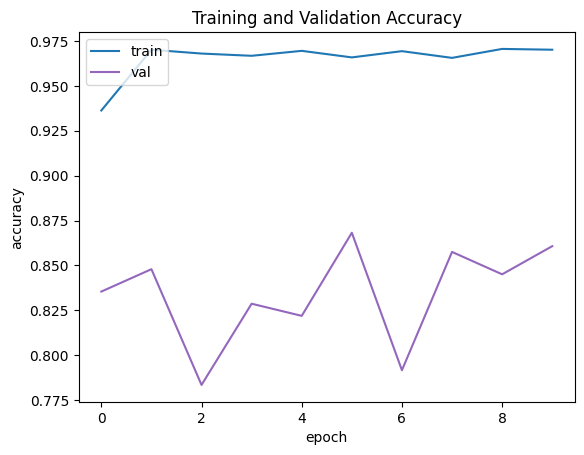

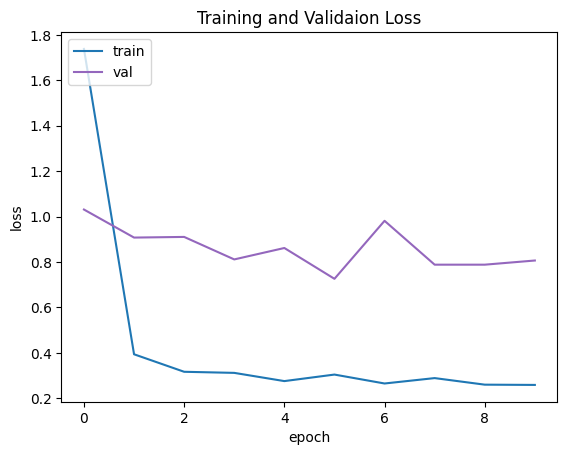

In [134]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'tab:blue')
plt.plot(epochs, val_acc, 'tab:purple')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'tab:blue')
plt.plot(epochs, val_loss, 'tab:purple')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [135]:
ev = transf_model.evaluate(test_images, test_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8562 - loss: 0.7560


94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step


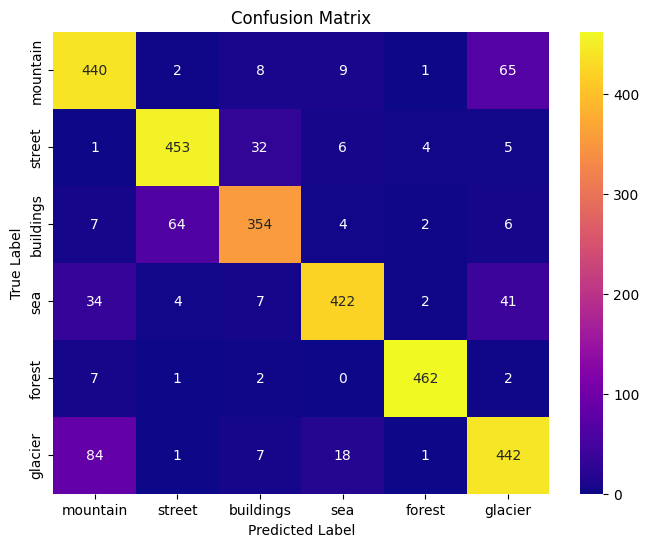

In [136]:
pred_probs = transf_model.predict(test_images)
pred = np.argmax(pred_probs , axis=1)
test_labels_np = np.array(test_labels)

cm = confusion_matrix(test_labels_np, pred, labels=[0, 1, 2, 3, 4, 5])

df_cm = pd.DataFrame(cm, index=sub_folder, columns=sub_folder)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="plasma", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [137]:
df_cm

,mountain,street,buildings,sea,forest,glacier
mountain,440,2,8,9,1,65
street,1,453,32,6,4,5
buildings,7,64,354,4,2,6
sea,34,4,7,422,2,41
forest,7,1,2,0,462,2
glacier,84,1,7,18,1,442


## Konversi Model

In [140]:
#save model
transf_model.save('model_img_classification_rev.keras')

In [139]:
!pip install tensorflowjs

In [141]:
#convert into tf.js
cnn_model.save('/kaggle/working/img_classification_fixed.h5')

In [142]:
!tensorflowjs_converter --input_format=keras /kaggle/working/img_classification_fixed.h5 tfjs_model

2025-05-02 13:09:07.920393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746191347.943008    5039 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746191347.949337    5039 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [144]:
import shutil
shutil.make_archive('/kaggle/working/tfjs_model', 'zip', '/kaggle/working/tfjs_model')

'/kaggle/working/tfjs_model.zip'

In [145]:
#tf lite
model = tf.keras.models.load_model('/kaggle/working/img_classification_fixed.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/kaggle/working/img_classification_fixed.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp1njs1lsw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138926659162512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926659167888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926659161744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926659166352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926659164816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926659170960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926659172112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926659170576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926659172880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926659170192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389266591686

W0000 00:00:1746191468.073765      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746191468.073803      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [146]:
transf_model.export('/kaggle/working/img_classification_fixed')

Saved artifact at '/kaggle/working/img_classification_fixed'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_4040')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138932751136528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138932751136912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138932751137296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138932751135376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138932751136144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138932751137104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138932749633104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138932749634256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138932749634640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138932749632720: TensorSpec(shape=(), dtype=tf.resource

In [32]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.3.0
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.16
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.4
ale-py==0.10.1
alembic==1.15.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.6.0
arrow==1.3.0
arviz==0.20.0
astropy==7.0.1
astropy-iers-data==0.2025.2.10.0.33.26
asttokens==3.0.0
astunparse==1.6.3
atpublic==4.1.0
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
bayesian-optimization==2.0.3
beartype==0.20.2
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.36.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blobfile==3.0.0
blosc2==3.1.0
bokeh==3.6.3
Boruta==0.4.3
boto3==1.37.29
botocore==1.37.29
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_hel

In [147]:
labels = sub_folder

with open('/kaggle/working/label.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")